In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create an account for Broad Single Cell Portal
# download data from https://singlecell.broadinstitute.org/single_cell/study/SCP1756/cortical-organoids-atlas#study-download

In [3]:
cwd = os.getcwd()

In [4]:
meta = pd.read_csv(cwd+'/data/meta_all.txt', sep='\t')
meta.drop(index=0, axis=0, inplace=True)
meta.drop(columns=['species','species__ontology_label',
                   'disease','disease__ontology_label',
                   'organ','organ__ontology_label',
                   'library_preparation_protocol'], inplace=True)
meta.rename(columns={'NAME':'CellID', 'biosample_id':'SampleID'}, inplace=True)
meta

/var/folders/gq/zhkl55292md4w3kdwkb01qjh0000gn/T/ipykernel_20814/4213564919.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(cwd+'/data/meta_all.txt', sep='\t')


,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type
1,AAACGAAAGACACAAT-3_1m-ATAC,ATAC-Org3,Mito 210 c1 b5,3850,5327,male,scATAC-seq,DerivedType_Organoid
2,AAACGAAAGACCTATC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,2070,2556,male,scATAC-seq,DerivedType_Organoid
3,AAACGAAAGATTGACA-2_1m-ATAC,ATAC-Org2,Mito 210 c1 b5,2708,3334,male,scATAC-seq,DerivedType_Organoid
4,AAACGAAAGCGTCTGC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,3970,5339,male,scATAC-seq,DerivedType_Organoid
5,AAACGAAAGGATATCA-3_1m-ATAC,ATAC-Org3,Mito 210 c1 b5,2590,3279,male,scATAC-seq,DerivedType_Organoid
...,...,...,...,...,...,...,...,...
777088,PCW18_TTTGTTGGTCACCGAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2298,5225,unknown,10X sequencing,PrimaryBioSample_Tissue
777089,PCW18_TTTGTTGGTGACAGCA-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,6308,24794,unknown,10X sequencing,PrimaryBioSample_Tissue
777090,PCW18_TTTGTTGGTTAGAAAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,1142,2062,unknown,10X sequencing,PrimaryBioSample_Tissue
777091,PCW18_TTTGTTGTCACCCTTG-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2881,7919,unknown,10X sequencing,PrimaryBioSample_Tissue


In [5]:
meta[['library_preparation_protocol__ontology_label','biosample_type']].value_counts()

library_preparation_protocol__ontology_label  biosample_type         
10X sequencing                                DerivedType_Organoid       601747
                                              PrimaryBioSample_Tissue     60806
single cell sequencing                        DerivedType_Organoid        53232
scATAC-seq                                    DerivedType_Organoid        38017
Slide-seq                                     DerivedType_Organoid        23290
Name: count, dtype: int64

In [6]:
meta['SampleID'].unique()

array(['ATAC-Org3', 'ATAC-Org1', 'ATAC-Org2', 'ATAC-Org5', 'ATAC-Org6',
       'ATAC-Org4', 'ATAC-Org8', 'ATAC-Org9', 'ATAC-Org7',
       'SlideSeq-1m-Org1', 'SlideSeq-1m-Org2', 'SlideSeq-1m-Org4',
       'SlideSeq-1m-Org3', 'SlideSeq-2m-Org1', 'SlideSeq-2m-Org2',
       'SlideSeq-2m-Org3', 'SlideSeq-3m-Org1', 'SlideSeq-3m-Org2',
       'SlideSeq-3m-Org3', 'Org1', 'Org2', 'Org3', 'Org4', 'Org5', 'Org6',
       'Org7', 'Org8', 'Org9', 'Org10', 'Org11', 'Org12', 'Org13',
       'Org14', 'Org15', 'Org16', 'Org17', 'Org18', 'Org19', 'Org20',
       'Org21', 'Org22', 'Org23', 'Org24', 'Org25', 'Org26', 'Org27',
       'Org28', 'Org29', 'Org30', 'Org31', 'Org32', 'Org33', 'Org40',
       'Org41', 'Org42', 'Org43', 'Org44', 'Org45', 'Org34', 'Org35',
       'Org36', 'Org37', 'Org38', 'Org39', 'Org46', 'Org47', 'Org48',
       'Org49', 'Org50', 'Org51', 'Org55', 'Org56', 'Org57', 'Org52',
       'Org53', 'Org54', 'Org58', 'Org59', 'Org60', 'Org61', 'Org62',
       'Org63', 'Org64', 'Org65', 'O

In [7]:
%%time
counts = scipy.io.mmread(cwd+'/data/expression_23days.txt')
counts = counts.transpose()
counts = scipy.sparse.csr_matrix(counts)
counts.shape

CPU times: user 31.9 s, sys: 695 ms, total: 32.6 s
Wall time: 33.4 s


(29736, 33694)

In [8]:
barcodes = pd.read_csv(cwd+'/data/NormExpression_23days_barcodes.txt', sep='\t', header=None)
barcodes.rename(columns={0:'CellID'}, inplace=True)
barcodes

,CellID
0,1_AAACGAACACGTGAGA-1_1_23d
1,1_AAACGAAGTCGAAACG-1_1_23d
2,1_AAACGAAGTGGCAGAT-1_1_23d
3,1_AAACGAAGTGGTTCTA-1_1_23d
4,1_AAACGAAGTTGGCCGT-1_1_23d
...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d
29732,3_TTTGGTTTCGGTTAGT-1_2_23d
29733,3_TTTGTTGAGACCATAA-1_2_23d
29734,3_TTTGTTGAGAGAAGGT-1_2_23d


In [9]:
genes = pd.read_csv(cwd+'/data/NormExpression_23days_genes.txt', sep='\t', header=None)
genes.rename(columns={0:'Genes'}, inplace=True)
genes

,Genes
0,RP11-34P13.3
1,FAM138A
2,OR4F5
3,RP11-34P13.7
4,RP11-34P13.8
...,...
33689,AC233755.2
33690,AC233755.1
33691,AC240274.1
33692,AC213203.1


In [10]:
sum(barcodes['CellID'].isin(meta['CellID']))

29736

In [11]:
a = meta['CellID'].isin(barcodes['CellID'])
b = meta[a]
meta_d23 = pd.merge(barcodes, b, on='CellID', how='left')
meta_d23

#a = meta['SampleID'].isin(['Org1', 'Org2', 'Org3', 'Org4', 'Org5', 'Org6'])
#meta_d23 = meta[a]
#meta_d23

,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type
0,1_AAACGAACACGTGAGA-1_1_23d,Org1,Mito 210 c1 b1,536,3724,male,10X sequencing,DerivedType_Organoid
1,1_AAACGAAGTCGAAACG-1_1_23d,Org1,Mito 210 c1 b1,2310,9184,male,10X sequencing,DerivedType_Organoid
2,1_AAACGAAGTGGCAGAT-1_1_23d,Org1,Mito 210 c1 b1,2070,6359,male,10X sequencing,DerivedType_Organoid
3,1_AAACGAAGTGGTTCTA-1_1_23d,Org1,Mito 210 c1 b1,1292,3468,male,10X sequencing,DerivedType_Organoid
4,1_AAACGAAGTTGGCCGT-1_1_23d,Org1,Mito 210 c1 b1,832,1809,male,10X sequencing,DerivedType_Organoid
...,...,...,...,...,...,...,...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d,Org6,PGP1 c1 b2,995,1825,male,10X sequencing,DerivedType_Organoid
29732,3_TTTGGTTTCGGTTAGT-1_2_23d,Org6,PGP1 c1 b2,3449,13964,male,10X sequencing,DerivedType_Organoid
29733,3_TTTGTTGAGACCATAA-1_2_23d,Org6,PGP1 c1 b2,1382,3670,male,10X sequencing,DerivedType_Organoid
29734,3_TTTGTTGAGAGAAGGT-1_2_23d,Org6,PGP1 c1 b2,1331,3713,male,10X sequencing,DerivedType_Organoid


In [12]:
adata = anndata.AnnData(X=counts,
                        obs=meta_d23,
                        var=genes)
adata

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 29736 × 33694
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type'
    var: 'Genes'

In [13]:
#adata.var_names_make_unique

In [14]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=200)

In [15]:
adata

AnnData object with n_obs × n_vars = 29736 × 20589
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type', 'n_genes'
    var: 'Genes', 'n_cells'

In [16]:
adata.X = scipy.sparse.csr_matrix(adata.X.copy())
adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())
#adata.layers['log2_counts'] = sc.pp.log1p(adata.layers['counts'].copy(), base=2)

In [17]:
%%time
random.seed(17)
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='SampleID')
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/269:   0%|                                      | 0/269 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 269/269: 100%|█| 269/269 [3:48:19<00:00, 116.82s/it, v_num=1, train_loss_s

`Trainer.fit` stopped: `max_epochs=269` reached.


Epoch 269/269: 100%|█| 269/269 [3:48:19<00:00, 50.93s/it, v_num=1, train_loss_st
CPU times: user 7h 31min 21s, sys: 1h 7min 6s, total: 8h 38min 27s
Wall time: 3h 48min 20s


In [18]:
random.seed(17)
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)
#adata.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


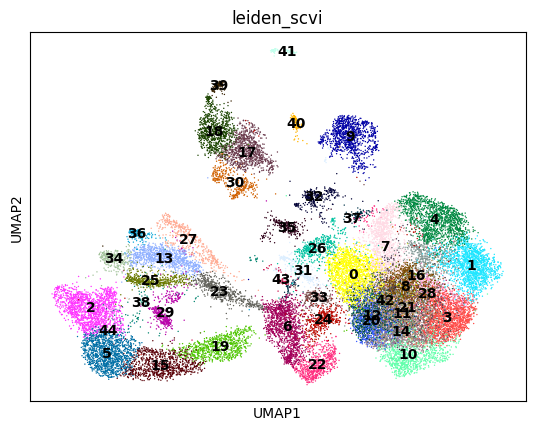

CPU times: user 52 s, sys: 2.23 s, total: 54.2 s
Wall time: 5min 44s


In [19]:
%%time
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
sc.tl.umap(adata, neighbors_key='neighbors_scvi')
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

In [20]:
adata.obs

,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type,n_genes,_scvi_batch,_scvi_labels,leiden_scvi
0,1_AAACGAACACGTGAGA-1_1_23d,Org1,Mito 210 c1 b1,536,3724,male,10X sequencing,DerivedType_Organoid,536,0,0,35
1,1_AAACGAAGTCGAAACG-1_1_23d,Org1,Mito 210 c1 b1,2310,9184,male,10X sequencing,DerivedType_Organoid,2310,0,0,14
2,1_AAACGAAGTGGCAGAT-1_1_23d,Org1,Mito 210 c1 b1,2070,6359,male,10X sequencing,DerivedType_Organoid,2068,0,0,27
3,1_AAACGAAGTGGTTCTA-1_1_23d,Org1,Mito 210 c1 b1,1292,3468,male,10X sequencing,DerivedType_Organoid,1291,0,0,23
4,1_AAACGAAGTTGGCCGT-1_1_23d,Org1,Mito 210 c1 b1,832,1809,male,10X sequencing,DerivedType_Organoid,831,0,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d,Org6,PGP1 c1 b2,995,1825,male,10X sequencing,DerivedType_Organoid,994,5,0,15
29732,3_TTTGGTTTCGGTTAGT-1_2_23d,Org6,PGP1 c1 b2,3449,13964,male,10X sequencing,DerivedType_Organoid,3449,5,0,16
29733,3_TTTGTTGAGACCATAA-1_2_23d,Org6,PGP1 c1 b2,1382,3670,male,10X sequencing,DerivedType_Organoid,1382,5,0,8
29734,3_TTTGTTGAGAGAAGGT-1_2_23d,Org6,PGP1 c1 b2,1331,3713,male,10X sequencing,DerivedType_Organoid,1329,5,0,8


In [21]:
adata.obs['CellID'] = adata.obs['CellID'].astype(str)
adata.obs['SampleID'] = adata.obs['SampleID'].astype(str)
adata.obs['donor_id'] = adata.obs['donor_id'].astype(str)
adata.obs['nGene'] = adata.obs['nGene'].astype(int)
adata.obs['nUMI'] = adata.obs['nUMI'].astype(int)
adata.obs['sex'] = adata.obs['sex'].astype(str)
adata.obs['library_preparation_protocol__ontology_label'] = adata.obs['library_preparation_protocol__ontology_label'].astype(str)
adata.obs['biosample_type'] = adata.obs['biosample_type'].astype(str)
adata.obs['leiden_scvi'] = adata.obs['leiden_scvi'].astype(str)

In [22]:
%%time
adata.write(cwd+'/outs/231228_uzquiano_d23_rna_scvi.h5ad')
scvi_model.save(cwd+'/outs/231228_uzquiano_d23_rna_scvi_model/')

CPU times: user 230 ms, sys: 2.06 s, total: 2.29 s
Wall time: 8.35 s
